In [1]:
import itertools
import numpy as np
import pandas as pd
import pprint as pp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import interp
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import auc, roc_curve, roc_auc_score

#%matplotlib qt
%matplotlib inline


In [2]:
'''
Read input data
'''
#filename = 'Data/2019H1BCleanedML.csv'
#filename = 'Data/2019H1BNumeric5.csv'
filename = '2019H1BNumericNew1.csv'
data = pd.read_csv(filename)

# dimension and objest types
print(data.shape, '\n')
print(data.dtypes)

data.head(5)

(20652, 13) 

CASE_STATUS                      int64
CASE_SUBMITTED                   int64
SOC_CODE                       float64
FULL_TIME_POSITION               int64
TOTAL_WORKER_POSITIONS           int64
AGENT_REPRESENTING_EMPLOYER    float64
H-1B_DEPENDENT                 float64
WILLFUL_VIOLATOR               float64
NumOfNaN                       float64
PERIOD_OF_EMPLOYMENT_LENGTH      int64
Annual_Wage                      int64
Fortune                          int64
EMPLOYER_REGION                float64
dtype: object


,CASE_STATUS,CASE_SUBMITTED,SOC_CODE,FULL_TIME_POSITION,TOTAL_WORKER_POSITIONS,AGENT_REPRESENTING_EMPLOYER,H-1B_DEPENDENT,WILLFUL_VIOLATOR,NumOfNaN,PERIOD_OF_EMPLOYMENT_LENGTH,Annual_Wage,Fortune,EMPLOYER_REGION
0,0,3,11.0,1,0,1.0,0.0,0.0,5.0,3,0,0,4.0
1,0,1,13.0,1,0,0.0,1.0,0.0,12.0,2,2,0,4.0
2,0,1,15.0,1,0,1.0,0.0,0.0,10.0,3,2,0,2.0
3,0,0,11.0,0,0,0.0,0.0,0.0,18.0,3,2,0,4.0
4,0,2,51.0,1,0,0.0,0.0,0.0,17.0,3,0,0,4.0


In [3]:
# distribution of target
data_size = len(data)
label_0 = len(data[data['CASE_STATUS'] == 0])  # DENIED
label_1 = len(data[data['CASE_STATUS'] == 1])  # CERTIFIED

print("% of CERTIFIED: {:.4f}".format(label_1*100/data_size))
print("% of DENIED: {:.4f}".format(label_0*100/data_size))

% of CERTIFIED: 75.0000
% of DENIED: 25.0000


In [4]:
# Check if there is nan data
data.isnull().sum()

CASE_STATUS                     0
CASE_SUBMITTED                  0
SOC_CODE                        0
FULL_TIME_POSITION              0
TOTAL_WORKER_POSITIONS          0
AGENT_REPRESENTING_EMPLOYER     5
H-1B_DEPENDENT                 20
WILLFUL_VIOLATOR               20
NumOfNaN                        0
PERIOD_OF_EMPLOYMENT_LENGTH     0
Annual_Wage                     0
Fortune                         0
EMPLOYER_REGION                 0
dtype: int64

In [5]:
'''
Preprocessing
'''
# Get column names that contain nan
nan_col = data.columns[data.isna().any()].tolist()
# fill 'nan' with mode number or new value
for col in nan_col:
    data[col] = data[col].fillna(data[col].mode()[0])
    
# Select features
cat_feature = data.columns.values.tolist()
#[cat_feature.remove(col) for col in ['CASE_STATUS','CASE_NUMBER','TOTAL_WORKER_POSITIONS','Wage_year']]
#[cat_feature.remove(col) for col in ['CASE_STATUS','CASE_NUMBER']]
[cat_feature.remove(col) for col in ['CASE_STATUS']]
print(cat_feature)

# Change types of the columns
for col in cat_feature:
    data[col] = data[col].astype(int)
print('\n')
print(data.dtypes)

data.head()

['CASE_SUBMITTED', 'SOC_CODE', 'FULL_TIME_POSITION', 'TOTAL_WORKER_POSITIONS', 'AGENT_REPRESENTING_EMPLOYER', 'H-1B_DEPENDENT', 'WILLFUL_VIOLATOR', 'NumOfNaN', 'PERIOD_OF_EMPLOYMENT_LENGTH', 'Annual_Wage', 'Fortune', 'EMPLOYER_REGION']


CASE_STATUS                    int64
CASE_SUBMITTED                 int64
SOC_CODE                       int64
FULL_TIME_POSITION             int64
TOTAL_WORKER_POSITIONS         int64
AGENT_REPRESENTING_EMPLOYER    int64
H-1B_DEPENDENT                 int64
WILLFUL_VIOLATOR               int64
NumOfNaN                       int64
PERIOD_OF_EMPLOYMENT_LENGTH    int64
Annual_Wage                    int64
Fortune                        int64
EMPLOYER_REGION                int64
dtype: object


,CASE_STATUS,CASE_SUBMITTED,SOC_CODE,FULL_TIME_POSITION,TOTAL_WORKER_POSITIONS,AGENT_REPRESENTING_EMPLOYER,H-1B_DEPENDENT,WILLFUL_VIOLATOR,NumOfNaN,PERIOD_OF_EMPLOYMENT_LENGTH,Annual_Wage,Fortune,EMPLOYER_REGION
0,0,3,11,1,0,1,0,0,5,3,0,0,4
1,0,1,13,1,0,0,1,0,12,2,2,0,4
2,0,1,15,1,0,1,0,0,10,3,2,0,2
3,0,0,11,0,0,0,0,0,18,3,2,0,4
4,0,2,51,1,0,0,0,0,17,3,0,0,4


## Model

In [6]:
# randomly split dataset
train, test = train_test_split(data, test_size=0.1, random_state=0)
    
# numpy array
X = train.iloc[:,1:]
y = train.iloc[:,0]
X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]

print("train {:5d} {:.2f}".format(len(train), len(train)/len(data)))
print("test {:5d}  {:.2f}".format(len(test), len(test)/len(data)))

train 18586 0.90
test  2066  0.10


In [7]:
'''
Best model
'''
best_clf = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=386, verbose=0,
                       warm_start=False) 

best_clf.fit(X, y)

pred = best_clf.predict(X_test)
te2 = round(np.mean(abs(y_test - pred)), 6)

f1 = f1_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
accuracy = accuracy_score(y_test, pred)

print('Testing Error:  {:.6f}'.format(te2))
print('Accuracy:  {:.6f}'.format(accuracy))
print('F1 score:  {:.6f}'.format(f1))
print('Precision: {:.6f}'.format(precision))
print('Recall:    {:.6f}'.format(recall))

Testing Error:  0.209100
Accuracy:  0.790900
F1 score:  0.870036
Precision: 0.816949
Recall:    0.930502


## Cross-validation

In [16]:
'''
Cross Validation
'''
# lists for plots
ConfusionBox = np.array([[0,0],[0,0]])
mean_fpr = np.linspace(0,1,100)
train_accuracy =[]
test_accuracy = []
TNR = []  
tprs = []
aucs = []
labels = []

# scores
f1_scores = []
accuracy_scores = []
te_scores = []
precision_scores = []
recall_scores = []

# evaluation methods
method = ['f1', 'accuracy', 'test error']

# shuffle split
shufspl = ShuffleSplit(train_size=0.8, test_size=0.2, n_splits=5)

# full data set
X = data.iloc[:,1:]
y = data.iloc[:,0]

i = 1
print("Start training...")
for train, test in shufspl.split(X):
    print("train", train, "\ntest", test)
    # fitting and prediction
    best_clf.fit(X.iloc[train], y.iloc[train])
    train_pred = best_clf.predict(X.iloc[train])
    cross_pred = best_clf.predict(X.iloc[test])
    rf_probs = best_clf.predict_proba(X.iloc[test])
    rf_probs = rf_probs[:, 1]
    
    # evaluation
    f1 = f1_score(y.iloc[test], cross_pred)
    accuracy = accuracy_score(y.iloc[test], cross_pred)
    error = round(np.mean(abs(y.iloc[test] - cross_pred)), 6)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)

    # scores.append(grade)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)
    te_scores.append(error)
    precision_scores.append(precision)
    recall_scores.append(recall)
    
    # Compute accuracy on the training set
    train_accuracy.append(accuracy_score(y.iloc[train], train_pred))
    # Compute accuracy on the test set
    test_accuracy.append(accuracy_score(y.iloc[test], cross_pred))

    # For confusion matrix
    CM = confusion_matrix(y.iloc[test], cross_pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    ConfusionBox += CM
    # Specificity or true negative rate
    TNR.append(TN/(TN+FP))
    
    # For ROC curve
    fpr, tpr, t = roc_curve(y.iloc[test], rf_probs)
    roc_auc = auc(fpr, tpr)
    tprs.append(interp(mean_fpr, fpr, tpr))
    aucs.append(roc_auc)
    label = [fpr, tpr, 'ROC fold %d (AUC = %0.2f)' % (i, roc_auc)]
    labels.append(label)
    i = i + 1   

    
print("\n-- Evaluation --")
print(f1_scores)
print('%s Scores: %.6f \n' % (method[0], np.mean(f1_scores)))
print(accuracy_scores)
print('%s Scores: %.6f \n' % (method[1], np.mean(accuracy_scores)))
print(te_scores)
print('%s Scores: %.6f \n' % (method[2], np.mean(te_scores)))

print(precision_scores)
print('%s Scores: %.6f \n' % ("precision", np.mean(precision_scores)))
print(recall_scores)
print('%s Scores: %.6f \n' % ("recall", np.mean(recall_scores)))

print("-- Specificity --")
print(TNR)
print('average = %.6f \n' % (np.mean(TNR)))

Start training...
train [ 5481 13388 11124 ... 14867 17902 11545] 
test [ 7433  3171  1186 ...  1616  1088 18109]
train [10312 11476  4244 ... 16721 20109  2492] 
test [ 1125  9916 11407 ... 15460  9373 15091]
train [10448 15187 13025 ... 12082  3616  9044] 
test [ 3971 17145  4448 ... 10198  1078 15066]
train [ 6010     3  7600 ... 16880   819 18786] 
test [ 3543  9662 15988 ... 19758 17945 12176]
train [12597  2623 14498 ...  4261  3147 17710] 
test [ 5367 13247  5899 ... 17795  4737 17691]

-- Evaluation --
[0.876360338573156, 0.8711177794448612, 0.8781793842034806, 0.8779900707085904, 0.8828639904134212]
f1 Scores: 0.877302 

[0.8019849915274752, 0.7920600338900993, 0.8017429193899782, 0.803679496489954, 0.8106995884773662]
accuracy Scores: 0.802033 

[0.198015, 0.20794, 0.198257, 0.196321, 0.1893]
test error Scores: 0.197967 

[0.8169491525423729, 0.8169491525423729, 0.8169491525423729, 0.8169491525423729, 0.8169491525423729]
precision Scores: 0.816949 

[0.9305019305019305, 0.930

### Confusion Matrix

In [17]:
'''
Customized confusion matrix
'''

def plot_confusion_matrix2(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
            
    fig.tight_layout()
    print('\nclasses:', len(np.unique(y)))
    plt.xlim(-0.5, len(np.unique(y))-0.5)
    plt.ylim(len(np.unique(y))-0.5, -0.5)
    
    return ax

Confusion matrix
[[ 1947  3071]
 [ 1018 14619]]

classes: 2


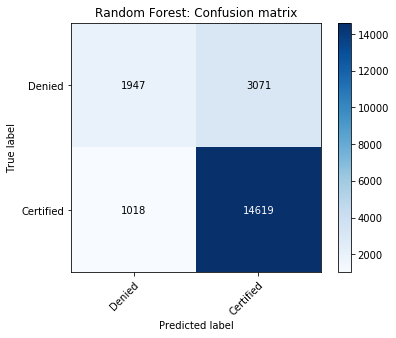

In [18]:
## Confusion matrix
plot_confusion_matrix2(ConfusionBox, classes=['Denied', 'Certified'], title='Random Forest: Confusion matrix')

### ROC Curve

-- AUC score --
[0.7980265286315109, 0.7715715503781262, 0.7873491732459406, 0.795099755176012, 0.8091263378878222]
average = 0.792235 



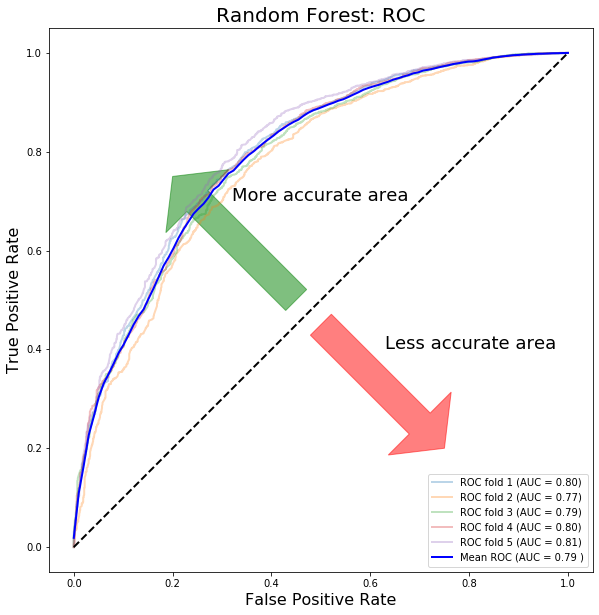

In [19]:
'''
Customized ROC curve
'''
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
print("-- AUC score --")
print(aucs)
print('average = %.6f \n' % (np.mean(aucs)))

# plot arrows
fig1 = plt.figure(figsize=[10,10])
ax1 = fig1.add_subplot(111, aspect = 'equal')
ax1.add_patch(patches.Arrow(0.45,0.5,-0.25,0.25, width=0.3, color='green', alpha = 0.5))
ax1.add_patch(patches.Arrow(0.5,0.45,0.25,-0.25, width=0.3, color='red', alpha = 0.5))

for label in labels:
    plt.plot(label[0], label[1], lw=2, alpha=0.3, label=label[2])

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)

plt.xlabel('False Positive Rate',fontsize = 16)
plt.ylabel('True Positive Rate',fontsize = 16)
plt.title('Random Forest: ROC',fontsize = 20)
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 18)
plt.text(0.63,0.4,'Less accurate area',fontsize = 18)
plt.show()

### Validation Curves

In [84]:
'''
Validation Curve
'''
from sklearn.model_selection import validation_curve

def run_validation_curves(param_name, param_range):
    lw = 2
    
    clf = RandomForestClassifier(n_jobs=-1, random_state=386)
    train_scores, test_scores = validation_curve(clf, X = X, y = y, 
                                                 param_name = param_name, 
                                                 param_range = param_range, 
                                                 cv = 3)

    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(param_range, train_mean, label="Training score", color="darkorange", lw=lw)
    plt.plot(param_range, test_mean, label="Cross-validation score", color="navy", lw=lw)

    plt.fill_between(param_range, train_mean-train_std, train_mean+train_std, alpha=0.2, color="darkorange", lw=lw)
    plt.fill_between(param_range, test_mean-test_std, test_mean+test_std, alpha=0.2, color="navy", lw=lw)
    
    plt.title("Random Forest Validation Curve for {}".format(param_name))
    plt.xlabel(param_name)
    plt.ylabel("Accuracy Score")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.grid()
    plt.show()
    
    return

In [85]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2', None]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 16]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pp.pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt', 'log2', None],
 'min_samples_leaf': [1, 2, 4, 8, 16],
 'min_samples_split': [2, 5, 10, 15, 20],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


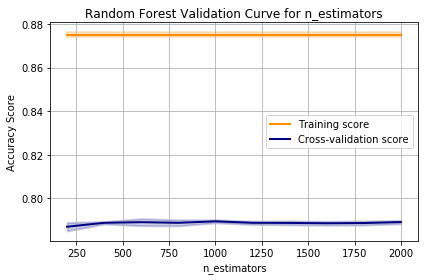

In [86]:
# 1. n_estimators
run_validation_curves("n_estimators", n_estimators)

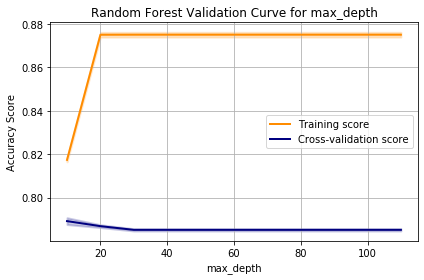

In [87]:
# 2. max_depth
param_range = max_depth
param_range.pop()
run_validation_curves("max_depth", param_range)

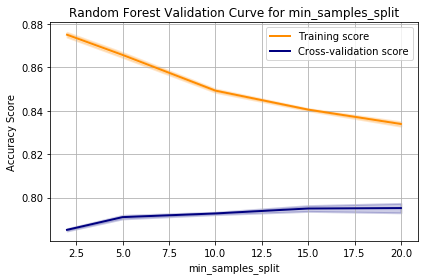

In [88]:
# 3. min_samples_split
run_validation_curves("min_samples_split", min_samples_split)

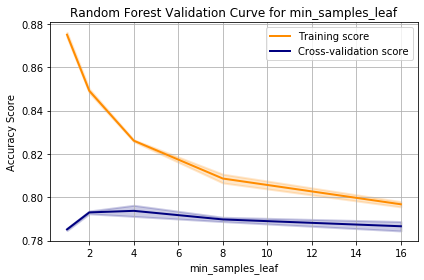

In [89]:
# 4. min_samples_leaf
run_validation_curves("min_samples_leaf", min_samples_leaf)